#Evaluación 1
Observatorio Barrow, Alaska

In [24]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

# Llamamos las bibliotecas para analizar las Series de Tiempo y Modelos de Pronóstico
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Sumprimimos los mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Parte 1**

In [2]:
# Tomar la dirección URL del archivo en formato 'raw'
url = 'https://raw.githubusercontent.com/Eduardo-Lares-Miranda/FisicaComputacional1/master/Evaluaci%C3%B3n%201/co2_brw_DailyData.txt'

# Definimos los nombres de las columnas
my_cols = ['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','Concentracion (CO2)','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag']
df_Barrow = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_Alaska = df_Barrow.copy()

# Reemplazamos los textos '-999.99' por 'NaN'
str_Nulo = -999.99
df_T0 = df_Alaska.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','Concentracion (CO2)','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag']
for cols in cols_list:
   df_T0[cols] = pd.to_numeric(df_T0[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_T1 = df_T0.copy()

#Con estas filas cree la nueva columna fecha uniendo el año, mes y día.
df_T1['Fecha'] = pd.to_datetime(df_T1[['Año','Mes','Dia']].astype(str).apply(' '.join, 1), format='%Y %m %d')

df_T1['Fecha'] = (pd.to_datetime(df_T1['Año'].astype(str) + '-' + df_T1['Mes'].astype(str) + '-' + df_T1['Dia'].astype(str)))

In [25]:
# Definimos un nuevo DataFrame para el análisis de los datos. 
# Será nuestro nuevo punto de partida.
df_T2 = df_T1.copy()
print(df_T2.head(3))
print(df_T2.tail(3))

   site_code   Año  Mes  Dia  ...  Elevacion  intake_height  qcflag      Fecha
0        NaN  1973    1    2  ...       11.0           16.0     NaN 1973-01-02
1        NaN  1973    1    3  ...       11.0           16.0     NaN 1973-01-03
2        NaN  1973    1    4  ...       11.0           16.0     NaN 1973-01-04

[3 rows x 18 columns]
       site_code   Año  Mes  Dia  ...  Elevacion  intake_height  qcflag      Fecha
17161        NaN  2019   12   28  ...       11.0          16.46     NaN 2019-12-28
17162        NaN  2019   12   29  ...       11.0          16.46     NaN 2019-12-29
17163        NaN  2019   12   30  ...       11.0          16.46     NaN 2019-12-30

[3 rows x 18 columns]


In [26]:
#Creamos una serie de tiempo desde el inicio de 1980 hasta fin de 2019, fijando la variable 'Fecha' como nuevo índice del DataFrame
df_T2 = df_T2.set_index('Fecha')
# Vamos a utilizar los últimos de datos, que corresponden al periodo 1980-2019
df_80 = df_T2[(df_T2['Año'] >= 1980) & (df_T2['Año'] < 2020)]
df_80.head()


,site_code,Año,Mes,Dia,Hora,Minuto,Segundo,time_decimal,Concentracion (CO2),value_std_dev,nvalue,Latitud,Longitud,Altitud,Elevacion,intake_height,qcflag
Fecha,,,,,,,,,,,,,,,,,
1980-01-01,NaN,1980,1,1,0,0,0,1980.000000,341.38,0.08,2,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-02,NaN,1980,1,2,0,0,0,1980.002732,341.65,0.21,21,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-03,NaN,1980,1,3,0,0,0,1980.005464,NaN,-99.99,0,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-04,NaN,1980,1,4,0,0,0,1980.008197,NaN,-99.99,0,71.323,-156.611,27.46,11.0,16.46,NaN
1980-01-05,NaN,1980,1,5,0,0,0,1980.010929,NaN,-99.99,0,71.323,-156.611,27.46,11.0,16.46,NaN


In [27]:
#Eliminamos las columnas que no necesitamos
df_CO2 = df_80.drop(['site_code','Año','Mes','Dia','Hora','Minuto','Segundo','time_decimal','value_std_dev','nvalue','Latitud','Longitud','Altitud','Elevacion','intake_height','qcflag'], axis=1)
df_CO2.head(3)

,Concentracion (CO2)
Fecha,
1980-01-01,341.38
1980-01-02,341.65
1980-01-03,NaN


In [28]:
#Usamos ts_test.ffill(axis = 0, inplace=True), para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible.
df_CO2.ffill(axis = 0, inplace=True)

**Parte 2**

In [12]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística
    plt.plot(df_ts, color='darkorange',label='Original')
    plt.plot(rolmean, color='darkgreen', label='Rolling Mean')
    plt.plot(rolstd, color='rebeccapurple', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desvación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [29]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1980 a 2019
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2019-12'
ts_80 = df_CO2.loc[start:end].copy()
ts_80.head()

,Concentracion (CO2)
Fecha,
1980-01-01,341.38
1980-01-02,341.65
1980-01-03,341.65
1980-01-04,341.65
1980-01-05,341.65


In [30]:
# Definimos la Serie de Tiempo con Concentracion de CO2 que vamos a estudiar, le damos un nombre genérico

ts_test = ts_80['Concentracion (CO2)'].copy()

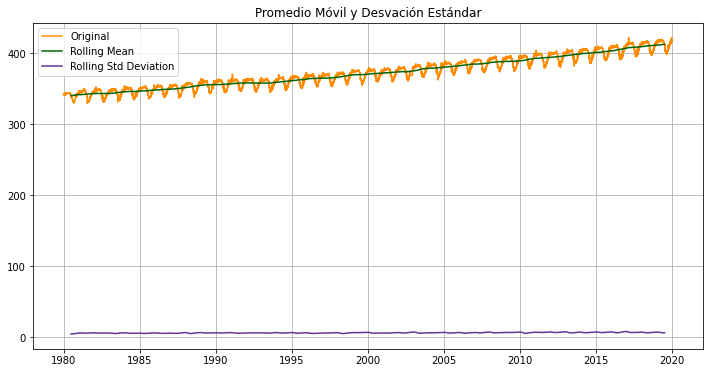

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -3.236940
p-value                            0.017944
#Lags Used                        37.000000
Number of Observations Used    14571.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [31]:
# Realizamos la Prueba de Estacionalidad de la Concentración de CO2
test_stationarity(ts_test)

Notamos que p es p>0.05 (0.017944) por lo que es estacionaria. 

Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. 

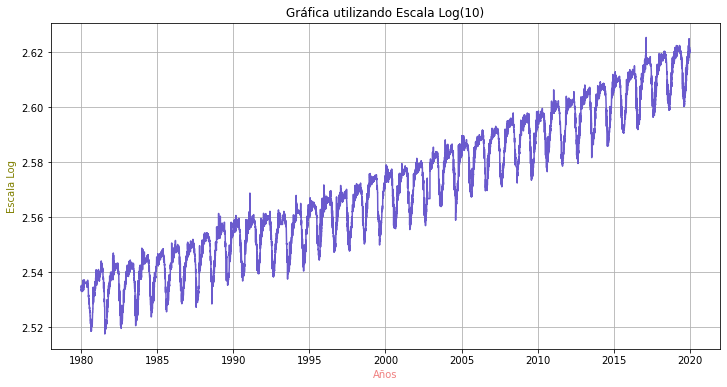

In [32]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log, color='slateblue')
plt.xlabel('Años',color='lightcoral')
plt.ylabel('Escala Log',color='olive')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

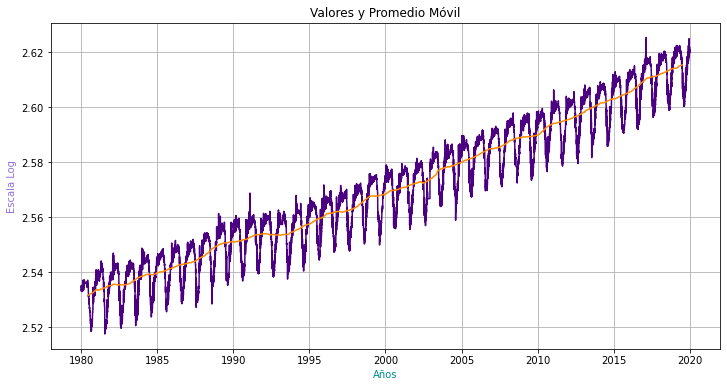

In [33]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log, color='indigo')
plt.plot(moving_avg, color = 'darkorange')
plt.xlabel('Años',color='darkcyan')
plt.ylabel('Escala Log',color='mediumpurple')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [34]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion (CO2), dtype: float64

In [35]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01   -0.000151
1980-07-02    0.000048
1980-07-03   -0.001153
1980-07-04   -0.001152
1980-07-05   -0.001164
Name: Concentracion (CO2), dtype: float64

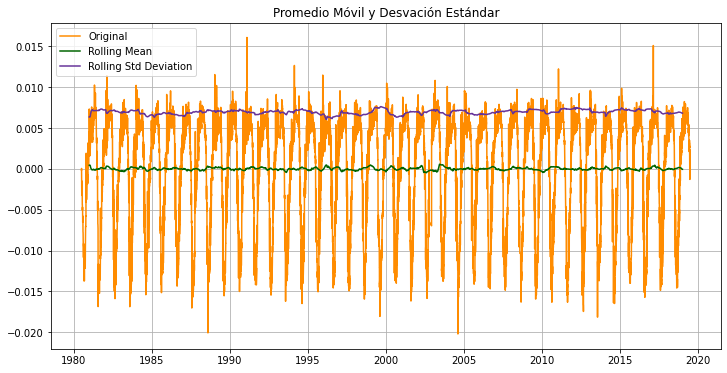

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.483177e+01
p-value                        1.894479e-27
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [36]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

El valor de p<0.05 ($3.766921*10^{-27}$), por lo que la serie estacionaria.

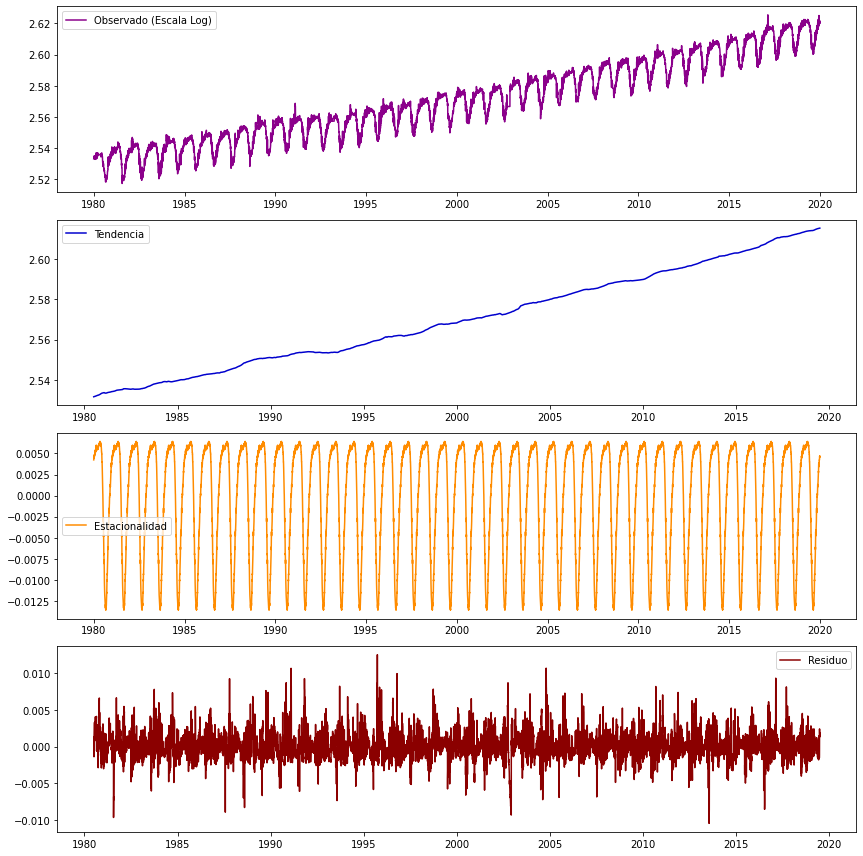

In [40]:
# Método de descomposición usando statsmodels.tsa

descomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# 3 componentes: tendencia, estacionalidad, residuo

trend = descomposition.trend
seasonal = descomposition.seasonal
residue = descomposition.resid

# Gráficas de componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)', color='darkmagenta')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='mediumblue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad',color='darkorange')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo', color='darkred')
plt.legend(loc='best')

# Esto es para disminuir espacio entre gráficos
plt.tight_layout();

La concentración va en aumento conforme van pasando los años.


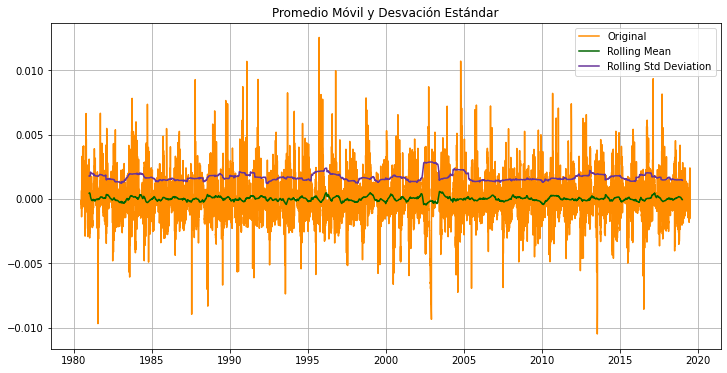

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -22.745264
p-value                            0.000000
#Lags Used                        12.000000
Number of Observations Used    14232.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [41]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

Por el valor de p sabemos que es estacionaria.

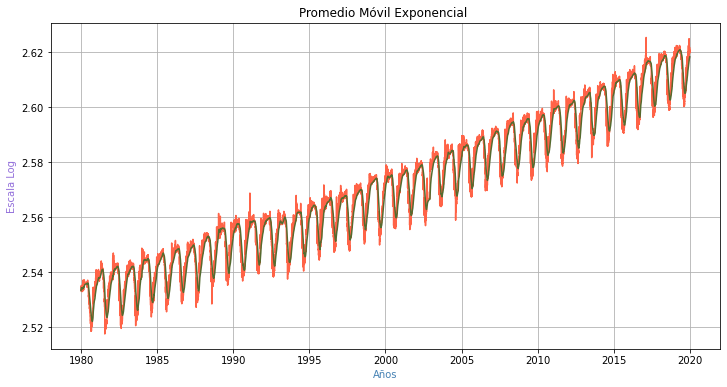

In [42]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=20).mean()
plt.plot(ts_test_log, color='tomato')
plt.plot(EWM_avg, color = 'darkolivegreen')
plt.xlabel('Años',color='steelblue')
plt.ylabel('Escala Log',color='mediumpurple')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [43]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion (CO2), dtype: float64

In [44]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01   -0.000151
1980-07-02    0.000048
1980-07-03   -0.001153
1980-07-04   -0.001152
1980-07-05   -0.001164
Name: Concentracion (CO2), dtype: float64

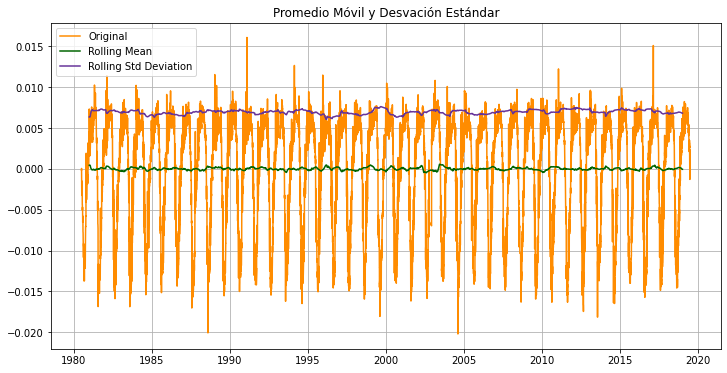

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.483177e+01
p-value                        1.894479e-27
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [45]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

Es estacionaria por el valor de p

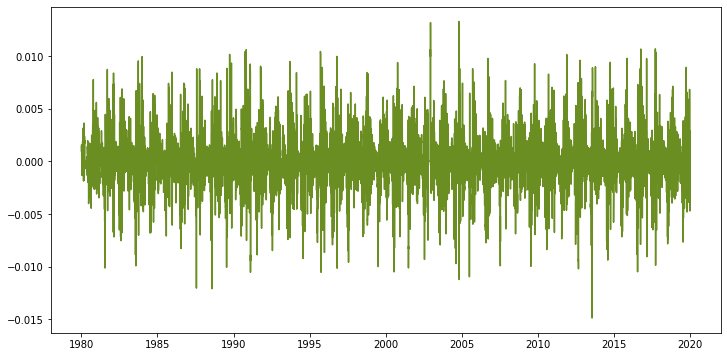

In [46]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff, color='olivedrab');

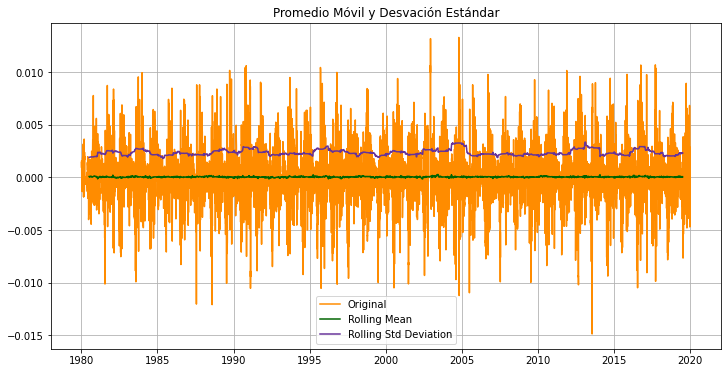

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.141389e+01
p-value                        7.139830e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [47]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [48]:
# Número de datos utilizados
len(ts_test_log_diff)

14602

**Modelo ARIMA**

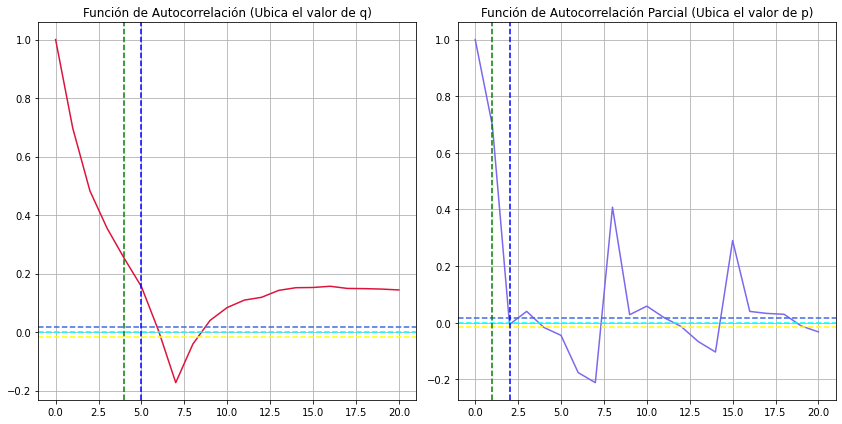

In [49]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf, color='crimson')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.axvline(x=5, linestyle='--', color='blue')
plt.grid()
plt.title('Función de Autocorrelación (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf, color='mediumslateblue')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=1, linestyle='--', color='green')
plt.axvline(x=2, linestyle='--', color='blue')
plt.grid()
plt.title('Función de Autocorrelación Parcial (Ubica el valor de p)')

plt.tight_layout()

**Modelo AR (Auto-REgresión)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               ARIMA Model Results                               
Dep. Variable:     D.Concentracion (CO2)   No. Observations:                14608
Model:                    ARIMA(2, 1, 0)   Log Likelihood               76726.319
Method:                          css-mle   S.D. of innovations              0.001
Date:                   Thu, 25 Feb 2021   AIC                        -153444.637
Time:                           07:54:52   BIC                        -153414.280
Sample:                       01-02-1980   HQIC                       -153434.552
                            - 12-30-2019                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        5.975e-06    7.8e-06      0.766      0.444   -9.32e-06    2.13e-05
ar.L1.D.Concentracion (CO2)    -0.1744      0.008    -21

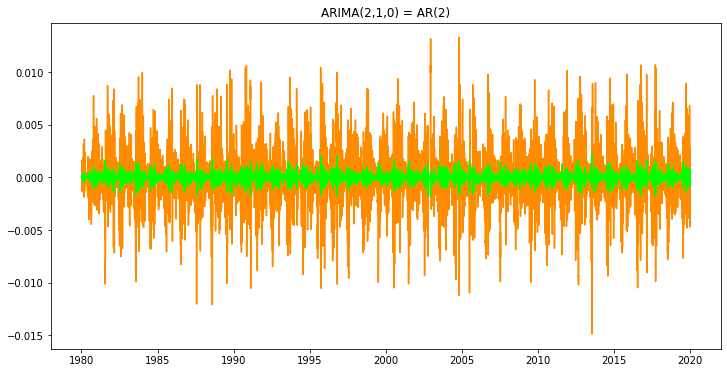

In [51]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff, color='darkorange')
plt.plot(results_AR.fittedvalues, color='lime')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

**Modelo MA (Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               ARIMA Model Results                               
Dep. Variable:     D.Concentracion (CO2)   No. Observations:                14608
Model:                    ARIMA(0, 1, 4)   Log Likelihood               76857.128
Method:                          css-mle   S.D. of innovations              0.001
Date:                   Thu, 25 Feb 2021   AIC                        -153702.256
Time:                           07:56:02   BIC                        -153656.720
Sample:                       01-02-1980   HQIC                       -153687.128
                            - 12-30-2019                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         5.96e-06   5.86e-06      1.017      0.309   -5.52e-06    1.74e-05
ma.L1.D.Concentracion (CO2)    -0.2046      0.008    -24

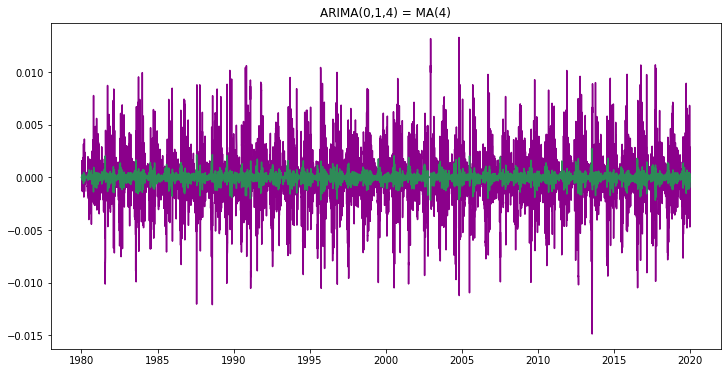

In [52]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff, color='darkmagenta')
plt.plot(results_MA.fittedvalues, color='seagreen')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

**Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                               ARIMA Model Results                               
Dep. Variable:     D.Concentracion (CO2)   No. Observations:                14608
Model:                    ARIMA(2, 1, 4)   Log Likelihood               76857.118
Method:                          css-mle   S.D. of innovations              0.001
Date:                   Thu, 25 Feb 2021   AIC                        -153698.235
Time:                           07:57:43   BIC                        -153637.521
Sample:                       01-02-1980   HQIC                       -153678.065
                            - 12-30-2019                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        5.958e-06   5.88e-06      1.013      0.311   -5.57e-06    1.75e-05
ar.L1.D.Concentracion (CO2)     0.2258        nan       

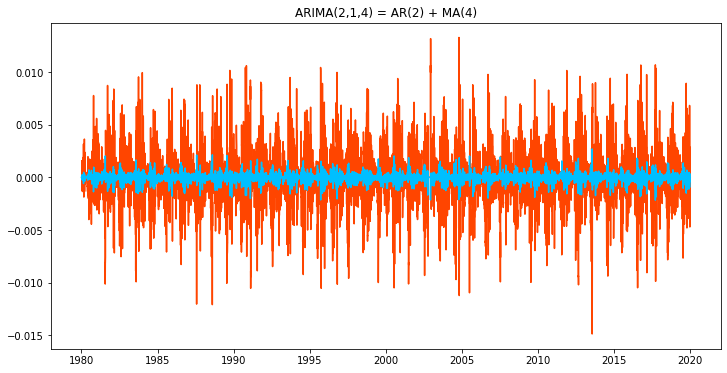

In [53]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff, color='orangered')
plt.plot(results_ARIMA.fittedvalues, color='deepskyblue')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Por el criterio AIC tiene dos principios:
- Bonda de Ajuste 
- Simplicidad del modelo o principio de parsimonia.\
El criterio AIC nos da:
- ARIMA (2,1,0): AIC= -153444.637
- ARIMA(0,1,4): AIC= -153702.256
- ARIMA(2,1,4): AIC= -153698.235\
El modelo de **ARIMA(0,1,4)**: **AIC=-153702.256** es el **mejor** modelo de las gráfica obtenidas.

In [54]:
#Contrasta la serie observada de concentraciones de CO2 ontra la construida por el modelo ARIMA.
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000006
1980-01-03   -0.000044
1980-01-04   -0.000050
1980-01-05   -0.000025
1980-01-06   -0.000014
                ...   
2019-12-26   -0.000392
2019-12-27   -0.000051
2019-12-28    0.000145
2019-12-29    0.000090
2019-12-30    0.000041
Length: 14608, dtype: float64


In [55]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.533587
1980-01-03    2.533537
1980-01-04    2.533531
1980-01-05    2.533556
dtype: float64
Fecha
2019-12-26    2.619723
2019-12-27    2.619939
2019-12-28    2.620104
2019-12-29    2.620237
2019-12-30    2.620854
dtype: float64


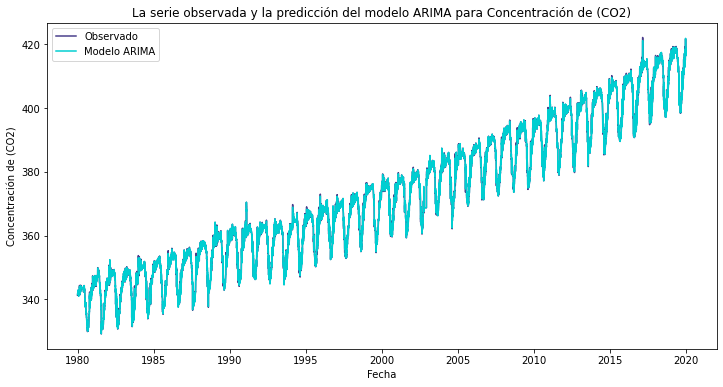

In [56]:
# Regresamos a la escala original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado', color='darkslateblue');
plt.plot(predictions_ARIMA, label='Modelo ARIMA', color='darkturquoise');
plt.xlabel('Fecha')
plt.ylabel('Concentración de (CO2)')
plt.title('La serie observada y la predicción del modelo ARIMA para Concentración de (CO2)')
plt.legend(loc='best');

In [57]:
#Calcula el error RMSE.
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.2879856147482848


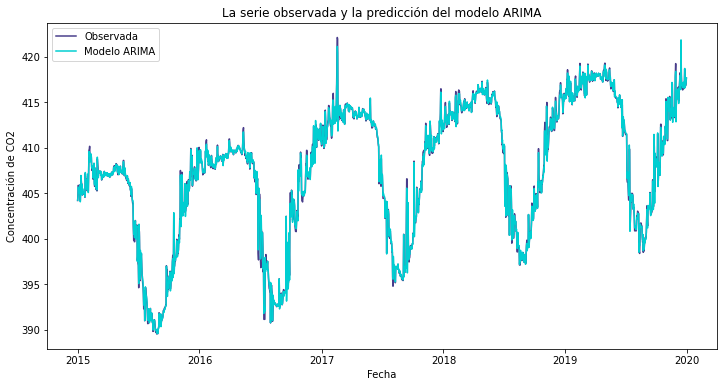

In [58]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada', color='darkslateblue');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA', color='darkturquoise');
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');
